In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import zipfile


Task 1: Data Preparation
Key Considerations

Use PIL (Python Imaging Library) for image processing
Normalize images to 0-1 range
Resize to consistent 28x28 pixels
Extract labels from directory structure

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:


# Unzip the dataset if needed
zip_path = '/content/drive/MyDrive/AI-ML/workshop4/Copy of devnagari digit.zip'
extract_path = '/content/drive/MyDrive/AI-ML/workshop4'

# Unzip the file if not already extracted
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
except FileExistsError:
    print("Dataset already extracted.")

# Set paths
train_data_dir = '/content/drive/MyDrive/AI-ML/workshop4/DevanagariHandwrittenDigitDataset/Train'
test_data_dir = '/content/drive/MyDrive/AI-ML/workshop4/DevanagariHandwrittenDigitDataset/Test'

# Data Preparation Function
def load_data(data_dir):
    """
    Load Devnagari digit images and labels from the specified directory

    Args:
    data_dir (str): Path to the directory containing digit images

    Returns:
    tuple: (images, labels)
    """
    images = []
    labels = []

    # Iterate through subdirectories (each representing a digit)
    for label, digit_dir in enumerate(sorted(os.listdir(data_dir))):
        digit_path = os.path.join(data_dir, digit_dir)

        # Ensure it's a directory
        if os.path.isdir(digit_path):
            for img_file in os.listdir(digit_path):
                img_path = os.path.join(digit_path, img_file)

                # Open and process image
                try:
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize((28, 28))  # Resize to 28x28
                    img_array = np.array(img) / 255.0  # Normalize to 0-1

                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    return np.array(images), np.array(labels)


In [7]:

# Load training and testing data
print("Loading training data...")
X_train, y_train = load_data(train_data_dir)
print(f"Training data shape: {X_train.shape}")

print("Loading testing data...")
X_test, y_test = load_data(test_data_dir)
print(f"Testing data shape: {X_test.shape}")

# Reshape images for FCN (flatten)
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Loading training data...
Training data shape: (17000, 28, 28)
Loading testing data...
Testing data shape: (3000, 28, 28)


## Task 2: Build FCN Model

**3 Hidden Layers**

1. 1st Layer: 64 neurons
2. 2nd Layer: 128 neurons
3. 3rd Layer: 256 neurons


* Sigmoid activation for hidden layers
* Softmax activation for output layer

In [8]:
# Build the FCN Model
model = keras.Sequential([
    # Input layer
    keras.layers.InputLayer(input_shape=(28*28,)),

    # First hidden layer
    keras.layers.Dense(64, activation='sigmoid'),

    # Second hidden layer
    keras.layers.Dense(128, activation='sigmoid'),

    # Third hidden layer
    keras.layers.Dense(256, activation='sigmoid'),

    # Output layer
    keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


summery of the model

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

## Task 3: Model Compilation
Configuration

Optimizer: Adam
Loss Function: Categorical Crossentropy
Metric: Accuracy

In [10]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Task 4: Model Training
Training Parameters

Batch Size: 128
Epochs: 20
Validation Split: 0.2

Callbacks for Optimization

In [11]:
# Prepare Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/AI-ML/workshop4/best_model.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


### Train the Model

In [12]:
# Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=20,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2804 - loss: 1.9869

107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2822 - loss: 1.9835 - val_accuracy: 0.0000e+00 - val_loss: 7.0040
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8104 - loss: 0.6230 - val_accuracy: 0.0000e+00 - val_loss: 8.0650
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8958 - loss: 0.3169 - val_accuracy: 0.0000e+00 - val_loss: 8.6498
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9376 - loss: 0.2127 - val_accuracy: 0.0000e+00 - val_loss: 9.0963
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9522 - loss: 0.1612 - val_accuracy: 0.0000e+00 - val_loss: 9.2870
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9637 - loss: 0.1281 - val_accuracy: 0.0000e+00 - val_loss: 9.4439


## Task 5: Model Evaluation

**Use model.evaluate()** on test set
Print test accuracy
Analyze performance metrics

In [13]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7836 - loss: 0.8269
Test Accuracy: 60.63%


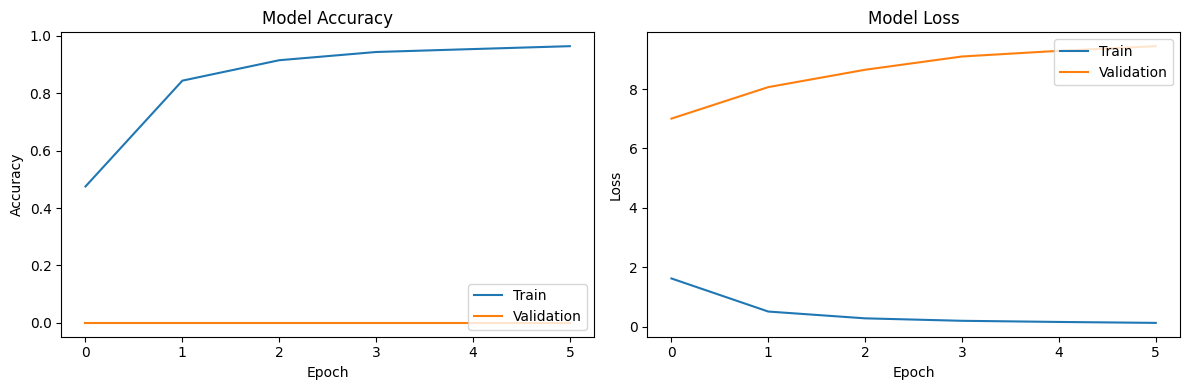

In [15]:
# Visualize Training History
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/AI-ML/workshop4/training_history.png')
plt.close()


## Task 6: Save and Load Model

* we can use model.save() to save model
* but her Model already saved via ModelCheckpoint callback

In [16]:
# Save model
# model.save('/content/drive/MyDrive/AI-ML/workshop4/final_model.h5')


## Task 7: Predictions

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


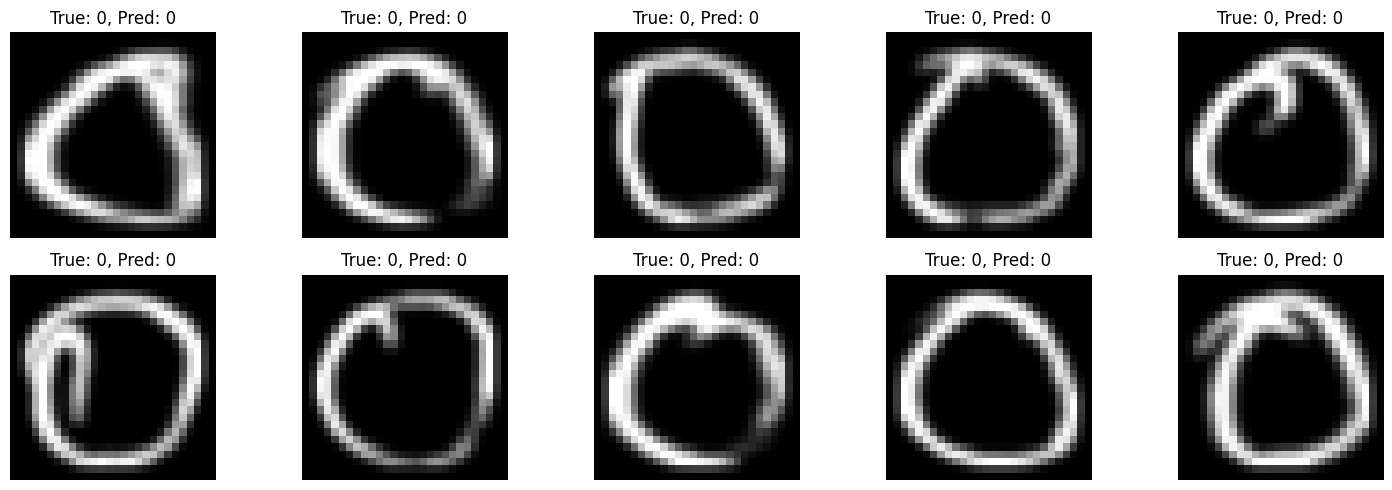

Training and evaluation complete!


In [17]:

# Load the Best Model
loaded_model = keras.models.load_model('/content/drive/MyDrive/AI-ML/workshop4/best_model.h5') # Model already saved via ModelCheckpoint callback

# Make Predictions
predictions = loaded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Visualize Some Predictions
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {np.argmax(y_test[i])}, Pred: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/AI-ML/workshop4/predictions.png')
plt.close()

print("Training and evaluation complete!")

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[296   0   0   0   1   0   1   2   0   0]
 [  1 293   1   1   3   0   1   0   0   0]
 [  1   6  12 266   1   8   5   1   0   0]
 [  0   1   7 269   1  21   1   0   0   0]
 [  1   7   0   0 279   8   3   2   0   0]
 [  0   1   0  48  18 231   2   0   0   0]
 [  1   5   1  22   6   5 234  26   0   0]
 [ 72   0   0   1   4   6  12 205   0   0]
 [159   5  24  20  24   7  44  17   0   0]
 [ 78  85   1  12  73   5  30  16   0   0]]
